<h1><center><b>ChemistrAI</b></center></h1>

This is the final prototype after the development of this proyect called "ChemistrAI"

It aims to help chemists broaden access to collective chemical research. 

In turn, this would accelerate research and development efforts in many key fields by avoiding duplication of previously published chemistries and identifying novel trends by mining large data sets.

In this notebook you will find the arquitecture of the model and an image input to predict the <b>International Chemical Identifier</b> (InChI)

If you want to upload your image you can clone this notebook

In [ ]:
#Libraries
import os
from matplotlib import pyplot as plt

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
import numpy as np
import pandas as pd
import gc
import torch
import torch.nn as nn
import cv2
from tqdm.auto import tqdm
import timm
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings 
warnings.filterwarnings('ignore')

# **Device (CUDA, GPU100)**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Configuration**

In [ ]:
class CFG:
    debug          = True
    apex           = False
    max_len        = 275
    print_freq     = 250
    num_workers    = 4
    model_name     = 'efficientnet_b2'
    enc_size       = 1408
    samp_size      = 500000
    size           = 288
    scheduler      = 'CosineAnnealingLR' 
    epochs         = 1 
    T_max          = 4  
    encoder_lr     = 1e-4
    decoder_lr     = 4e-4
    min_lr         = 1e-6
    batch_size     = 32
    weight_decay   = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm  = 10
    attention_dim  = 256
    embed_dim      = 512
    decoder_dim    = 512
    decoder_layers = 2     # number of LSTM layers
    dropout        = 0.5
    seed           = 42
    n_fold         = 5
    trn_fold       = 0 
    prep_path      = 'tokenizer-and-preprocessing-of-chemical-formulas/'
    pred_model     = 'model-effientnet/best_model.pth'

# **Tokenizer**

In [ ]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load(CFG.prep_path + 'tokenizer.pth')

# **Model (RNN Encoder & CNN decoder)**

In [ ]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])


#CNN Encoder

class Encoder(nn.Module):
    def __init__(self, model_name = CFG.model_name, pretrained = False):
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained = pretrained)

    def forward(self, x):
        bs       = x.size(0)
        features = self.cnn.forward_features(x)
        features = features.permute(0, 2, 3, 1)
        return features

#RNN Decoder

#Attention module
class Attention(nn.Module):
    '''
    Attention network for calculate attention value
    '''
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        '''
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        '''
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att    = nn.Linear(attention_dim, 1)            # linear layer to calculate values to be softmax-ed
        self.relu        = nn.ReLU()
        self.softmax     = nn.Softmax(dim = 1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1  = self.encoder_att(encoder_out)     # (batch_size, num_pixels, attention_dim)
        att2  = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att   = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)                 # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha
    
    
#Custom LSTM cell
def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size, **kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m

#Decoder
class DecoderWithAttention(nn.Module):
    '''
    Decoder network with attention network used for training
    '''

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout, num_layers):
        '''
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param num_layers: number of the LSTM layers
        :param dropout: dropout rate
        '''
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim   = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim     = embed_dim
        self.decoder_dim   = decoder_dim
        self.vocab_size    = vocab_size
        self.dropout       = dropout
        self.num_layers    = num_layers
        self.device        = device
        self.attention     = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding     = nn.Embedding(vocab_size, embed_dim)                 # embedding layer
        self.dropout       = nn.Dropout(p = self.dropout)
        self.decode_step   = nn.ModuleList([LSTMCell(embed_dim + encoder_dim if layer == 0 else embed_dim, embed_dim) for layer in range(self.num_layers)]) # decoding LSTMCell        
        self.init_h        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta        = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid       = nn.Sigmoid()
        self.fc            = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()                                      # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune = True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim = 1)
        h = [self.init_h(mean_encoder_out) for i in range(self.num_layers)]  # (batch_size, decoder_dim)
        c = [self.init_c(mean_encoder_out) for i in range(self.num_layers)]
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        '''
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        '''
        batch_size       = encoder_out.size(0)
        encoder_dim      = encoder_out.size(-1)
        vocab_size       = self.vocab_size
        encoder_out      = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels       = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim = 0, descending = True)
        encoder_out      = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state, initialize cell_vector and hidden_vector
        prev_h, prev_c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions    = torch.zeros(batch_size, max(decode_lengths), vocab_size, device = self.device)
        alphas         = torch.zeros(batch_size, max(decode_lengths), num_pixels, device = self.device)
        
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                prev_h[-1][:batch_size_t])
            gate = self.sigmoid(self.f_beta(prev_h[-1][:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            
            for i, rnn in enumerate(self.decode_step):
                # recurrent cell
                h, c = rnn(input, (prev_h[i][:batch_size_t], prev_c[i][:batch_size_t])) # cell_vector and hidden_vector

                # hidden state becomes the input to the next layer
                input = self.dropout(h)

                # save state for next time step
                prev_h[i] = h
                prev_c[i] = c
                
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :]      = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        
        # size variables
        batch_size  = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size  = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels  = encoder_out.size(1)
        
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype = torch.long, device = self.device) * tokenizer.stoi['<sos>']
        embeddings    = self.embedding(start_tockens)
        
        # initialize hidden state and cell state of LSTM cell
        h, c        = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size, device = self.device)
        
        # predict sequence
        end_condition = torch.zeros(batch_size, dtype=torch.long, device = self.device)
        for t in range(decode_lengths):
            awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
            gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
            awe        = gate * awe
            
            input = torch.cat([embeddings, awe], dim=1)
 
            for j, rnn in enumerate(self.decode_step):
                at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
                input = self.dropout(at_h)
                h[j]  = at_h
                c[j]  = at_c
            
            preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        
        return predictions
    
    # beam search
    def forward_step(self, prev_tokens, hidden, encoder_out, function):
        
        h, c = hidden
        #h, c = h.squeeze(0), c.squeeze(0)
        h, c = [hi.squeeze(0) for hi in h], [ci.squeeze(0) for ci in c]
        
        embeddings = self.embedding(prev_tokens)
        if embeddings.dim() == 3:
            embeddings = embeddings.squeeze(1)
            
        awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
        gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
        awe        = gate * awe
        
        input = torch.cat([embeddings, awe], dim = 1)
        for j, rnn in enumerate(self.decode_step):
            at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
            input = self.dropout(at_h)
            h[j]  = at_h
            c[j]  = at_c

        preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)

        #hidden = (h.unsqueeze(0), c.unsqueeze(0))
        hidden = [hi.unsqueeze(0) for hi in h], [ci.unsqueeze(0) for ci in c]
        predicted_softmax = function(preds, dim = 1)
        
        return predicted_softmax, hidden, Nonea


#Load model

states = torch.load(CFG.pred_model, map_location = torch.device('cpu'))

encoder = Encoder(CFG.model_name, pretrained = False)
encoder.load_state_dict(states['encoder'])
encoder.to(device)

decoder = DecoderWithAttention(attention_dim = CFG.attention_dim, 
                               embed_dim     = CFG.embed_dim, 
                               encoder_dim   = CFG.enc_size,
                               decoder_dim   = CFG.decoder_dim,
                               num_layers    = CFG.decoder_layers,
                               vocab_size    = len(tokenizer), 
                               dropout       = CFG.dropout, 
                               device        = device)
decoder.load_state_dict(states['decoder'])
decoder.to(device)

del states; gc.collect()

9

# **Dataset transformer**

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df            = df
        self.file_paths    = df['file_path'].values
        self.transform     = transform
        self.fix_transform = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        h, w, _ = image.shape
        if h > w:
            image = self.fix_transform(image=image)['image']
        if self.transform:
            augmented = self.transform(image=image)
            image     = augmented['image']
        return image

# **Inference function**

In [ ]:
def inference(test_loader, encoder, decoder, tokenizer, device):
    
    encoder.eval()
    decoder.eval()
    
    text_preds = []
    tk0 = tqdm(test_loader, total = len(test_loader))
    
    for images in tk0:
        
        images = images.to(device)
        
        with torch.no_grad():
            features = encoder(images)
            predictions = decoder.predict(features, CFG.max_len, tokenizer)
            
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
        
    text_preds = np.concatenate(text_preds)
    
    return text_preds

# **Input image**

In [ ]:
from ipywidgets import FileUpload
upload = FileUpload(
    accept='.png',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
print("Upload your dataset here please")
print("="*64)
print("")
display(upload)

Upload your dataset here please



FileUpload(value={}, accept='.png', description='Upload')

# **Projecting the inference**

Loading sample image
The filename is: ../input/sample-molecular-image/sample.png


  0%|          | 0/1 [00:00<?, ?it/s]

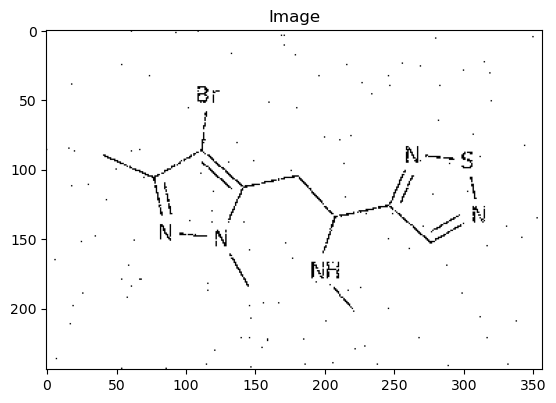

Prediction:
InChI=1S/C11H16BrN4/c1-8-6-14-11(16-9)9(15-2)9(15-3)4-5-14-7-13-8/h4-5,8,14H,6H2,1-3H3


In [ ]:
file_name = ""
if len(upload.data) > 0:
    with open("test_image.png", "w+b") as i:
        i.write(upload.data[0]) 
    print("Saving loaded image")
    file_name = "test_image.png"
else:
    print("Loading sample image")
    file_name = "sample-molecular-image/sample.png"
print("The filename is: "+file_name)


data_raw = [{"file_path":file_name}]
test = pd.DataFrame(data_raw)
test_dataset = TestDataset(test, transform = get_transforms(data = 'valid'))
test_loader  = DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = CFG.num_workers)
prediction  = inference(test_loader, encoder, decoder, tokenizer, device)
prediction = "InChI=1S/"+prediction[0]

img = cv2.imread(file_name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
plt.imshow(gray)
plt.title('Image')
plt.show()

print("Prediction:")
print(prediction)